In [1]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from functools import reduce

In [7]:
# função para pegar as partidas de um time específico

def team_matches(team, df_matches):
    team_matches = df_matches.query((f'home_team == "{team}" or away_team == "{team}"'))
    return team_matches.sort_values(by='match_date', ascending=False)

In [8]:
# Partidas da Holanda

team = "Netherlands"
df_matches = sb.matches(competition_id=55, season_id=282) # partidas da eurocopa 2024

team_matches = team_matches(team, df_matches)

In [10]:
# Eventos da partida Holanda x Inglaterra
match = sb.events(match_id=3942819)

# função para tratar eventos da partida
def split_locations(df):
    df[['x', 'y']] = df['location'].apply(pd.Series)
    df[['pass_end_x', 'pass_end_y']] = df['pass_end_location'].apply(pd.Series) # separar ponto final dos passes
    df[['carry_end_x', 'carry_end_y']] = df['carry_end_location'].apply(pd.Series) # separar ponto final das conduções
    return df

In [11]:
# Tratando os eventos da partida

match_events = split_locations(match)

In [12]:
# Criando uma lista de jogadores da equipe analisada
team = "Netherlands"

players_team = [match_events.query(f'team == "{team}"')['player'].unique()]

players_team = list(players_team[0][1:])

In [27]:
# Lista de eventos
events_types = ['Ball Receipt*', 'Pass', 'Dribble', 'Shot', 'Interception', 'Foul Commited', 'Foul Won', 'Miscontrol', 'Block', 'Dispossessed', 'Ball Recovery']

# Lista de acoes com bola (touches)
touches=['Pass', 'Ball Receipt*', 'Carry', 'Clearance', 'Foul Won', 'Block',
'Ball Recovery', 'Duel', 'Dribble', 'Interception', 'Miscontrol', 'Shot']


# Iterador (for) para tabela de agregações

In [31]:
players_dicts = []

for player in players_team:
    player_dict = {}
    player_dict['Name'] = player
    for event in events_types:
        specific_event = match_events[(match_events.player==player)&(match_events.type==event)]
        data_event = len(specific_event)
        player_dict[event] = data_event
    player_long_passes = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_length>30)]
    player_dict['Long Passes'] = len(player_long_passes)
    player_goals = match_events[(match_events.type=="Shot")&(match_events.player==player)&(match_events.shot_outcome=="Goal")]
    player_dict['Goals'] = len(player_goals)
    player_assists = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_goal_assist==True)]
    player_dict['Assists'] = len(player_assists)
    player_crosses = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_cross==True)]
    player_dict['Crosses'] = len(player_crosses)
    players_dicts.append(player_dict)






In [32]:
df_team = pd.DataFrame(players_dicts)

In [33]:
df_team

,Name,Ball Receipt*,Pass,Dribble,Shot,Interception,Foul Commited,Foul Won,Miscontrol,Block,Dispossessed,Ball Recovery,Long Passes,Goals,Assists,Crosses
0,Virgil van Dijk,53,66,0,1,1,0,0,0,0,0,2,10,0,0,0
1,Nathan Aké,33,38,1,0,0,0,0,0,2,0,1,5,0,0,1
2,Stefan de Vrij,53,62,0,0,4,0,1,0,1,0,0,10,0,0,0
3,Jerdy Schouten,48,54,0,0,0,0,1,1,0,0,5,6,0,0,0
4,Denzel Dumfries,41,30,1,2,0,0,1,1,3,2,0,4,0,0,0
5,Bart Verbruggen,28,36,0,0,0,0,0,0,0,0,6,19,0,0,0
6,Memphis Depay,11,8,0,0,0,0,0,1,0,1,0,1,0,0,0
7,Xavi Simons,48,40,1,2,1,0,2,1,2,1,2,7,1,0,0
8,Tijjani Reijnders,36,40,0,0,2,0,1,0,3,0,4,3,0,0,0
9,Donyell Malen,14,4,0,1,1,0,0,1,1,1,2,1,0,0,0


# Gráficos

### Bolas recebidas

In [ ]:
# Função para localização de eventos

def event_map(event, player):
    df_event = match_events[(match_events.player==player)&(match_events.type==event)]

    # campo
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_zorder=2, line_color='black')
    fig, ax = pitch.draw(figsize=(16, 11),constrained_layout=True, tight_layout=False)
    fig.set_facecolor('white')

    # bolas recebidas
    pitch.arrows(df_event.x, df_event.y,
             df_event.x, df_event.y, width=8, 
             headwidth=8, headlength=5, color=color, ax=ax, zorder=2, label = event)
    
    ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')
    ax_title = ax.set_title(f'{player} {event.lower()} on the pitch', fontsize=30,color='black')


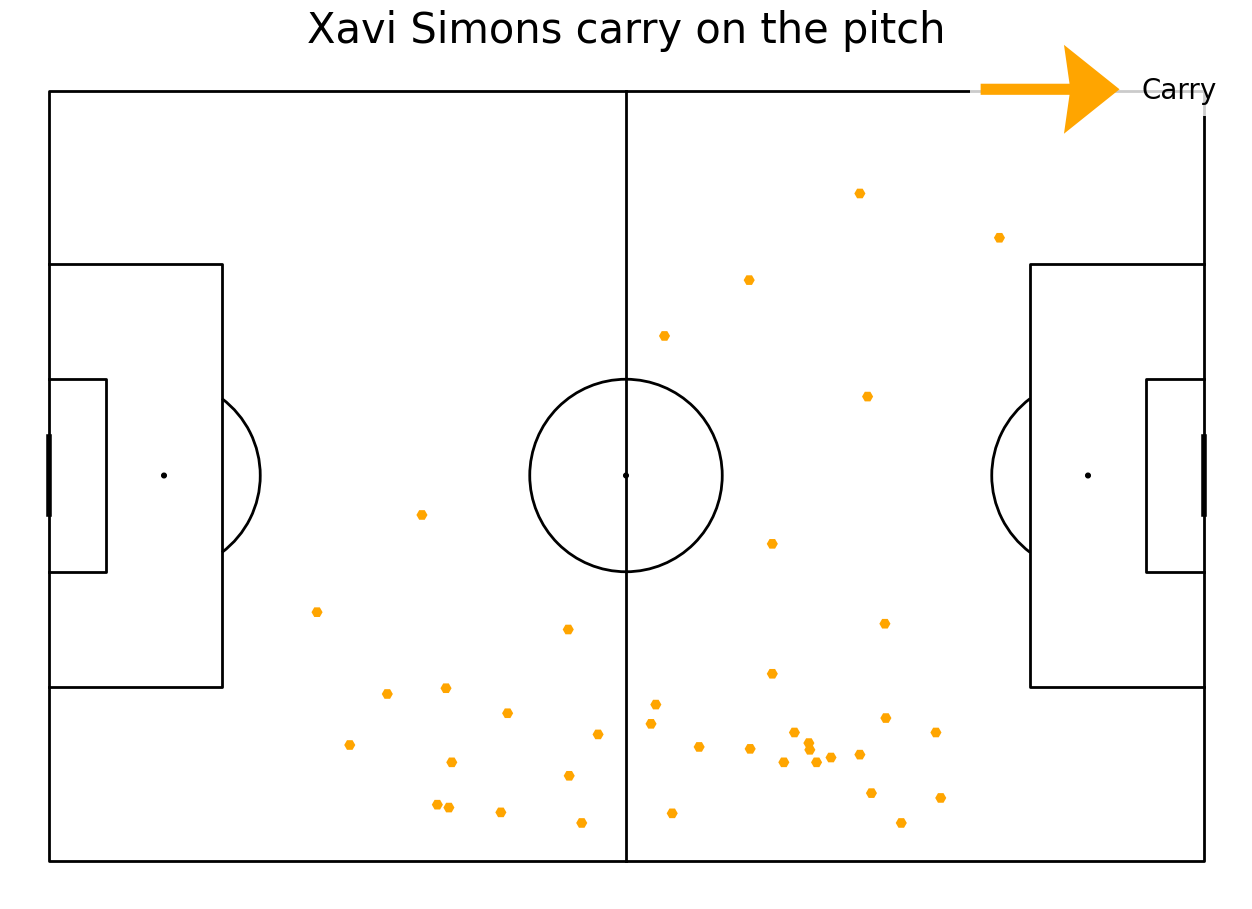

In [39]:
event = 'Carry'
player = 'Xavi Simons'
color = 'orange'

event_map(event,player)